# Numerical Field Propagation Field Between Parallel Planes
### Convolution-Based Technique: Angular Spectrum Method

Angular Spectrum과 Fresnel 근사에 기반한 Numerical propagation은 컨볼루션 적분으로 표현된다. 따라서, 컨볼루션 정리와 FFT를 사용하여 전달된 필드를 효과적으로 계산할 수 있다.

In [ ]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
cm, mm, um, nm = 1e-2, 1e-3, 1e-6, 1e-9

In [ ]:
def pad_image(field, target_shape, padval=0, mode='constant'):
    """
        Pads a 2D complex field up to target_shape in size
        Padding is done such that when used with crop_image(), odd and even dimensions are handled correctly to properly undo the padding.

        field:          the field to be padded. May have as many leading dimensions as necessary (e.g., batch or channel dimensions)
        target_shape:   the 2D target output dimensions. If any dimensions are smaller than field, no padding is applied
        padval:         the real number value to pad by (default: 0)
        mode:           padding mode for numpy or torch
    """
    size_diff = np.array(target_shape) - np.array(field.shape[-2:])
    odd_dim = np.array(field.shape[-2:]) % 2

    # pad the dimensions that need to increase in size
    if (size_diff > 0).any():
        pad_total = np.maximum(size_diff, 0)
        pad_front = (pad_total + odd_dim) // 2
        pad_end = (pad_total + 1 - odd_dim) // 2

        leading_dims = field.ndim - 2  # only pad the last two dims
        if leading_dims > 0:
            pad_front = np.concatenate(([0] * leading_dims, pad_front))
            pad_end = np.concatenate(([0] * leading_dims, pad_end))
        return np.pad(field, tuple(zip(pad_front, pad_end)), mode, constant_values=padval)

    else:
        return field


In [ ]:

def crop_image(field, target_shape):
    """
        Crops a 2D field, see pad_image() for detail
        No cropping is done if target_shape is already smaller than field
    """
    if target_shape is None:
        return field

    size_diff = np.array(field.shape[-2:]) - np.array(target_shape)
    odd_dim = np.array(field.shape[-2:]) % 2

    # crop dimensions that need to decrease in size
    if (size_diff > 0).any():
        crop_total = np.maximum(size_diff, 0)
        crop_front = (crop_total + 1 - odd_dim) // 2
        crop_end = (crop_total + odd_dim) // 2

        crop_slices = [slice(int(f), int(-e) if e else None) for f, e in zip(crop_front, crop_end)]
        return field[(..., *crop_slices)]
    else:
        return field

# 1. Make aperture at image plane (z=0)

$z_0$ 위치에서 Source plane (aperture) 생성. 이때, 단순한 binary 함수가 아닌, 다음의 수식을 통해 aperture를 생성한다.

$g(x, y;z_0)=\exp^{[-(\frac{\sqrt{x^2+y^2}}{D/2})^{50}]}$.

Source plane에서 $x$축, $y$축에 대한 표본화 간격 및 표본화 개수는 각각 10㎛, 1000을 따르며, aperture의 크기 $D=1$㎜로 설정한다.

- sampling interval: 10㎛
- the # of sample points: 1000
- source plane size: 10㎛ * 1000 = 10㎜
- aperture size: 1㎜


In [4]:
def source_field(image_size, aperture_size, sampling_interval, num_samples):

    # Grid Coordinate
    x_point = np.linspace(-image_size/2, image_size/2 - sampling_interval, num=num_samples)
    y_point = np.linspace(-image_size/2, image_size/2 - sampling_interval, num=num_samples)
    grid_x, grid_y = np.meshgrid(x_point, y_point)

    # Aperture
    aperture = np.sqrt((grid_x ** 2) + (grid_y ** 2)) / (aperture_size / 2)
    aperture = np.exp(-np.power(aperture, 50))
    return aperture

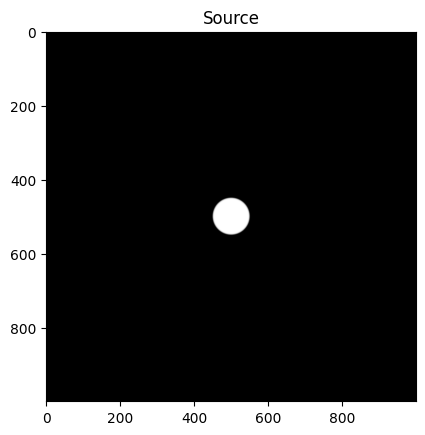

In [5]:
num_samples = 1000
sampling_interval = 10 * um
image_size = num_samples * sampling_interval
aperture_size = 1 * mm

# Make aperture at image plane (z=0)
source = source_field(image_size, aperture_size, sampling_interval, num_samples)

plt.imshow(source, cmap="gray")
plt.title("Source")
plt.show()

# 2. Angular Spectrum Method (ASM)

Angular Spectrum Method를 통해 $z_0$에 위치한 source를 $d$만큼 떨어진 거리의 destination field로 전파하는 방법은 다음과 같다.

$g[m, n; z] = FFT^{-1}[FFT[g[m, n; z_0]] H[p, q; d]]$

1. $z_0$에 위치한 Image domain의 source plane을 Fourier Transform 한다.
2. Fourier domain에서 source plane을 $d$만큼 전파할 Transfer function (kernel)을 계산한다.
3. 1의 결과와 2의 결과를 곱한다. (Convolution in image domain)
4. 3의 결과에 inverse Fourier Transform 연산을 수행한다.


이때, Fourier domain에서의 transfer function $H$는 다음과 같이 계산할 수 있다.

$H[p, q; d] = \begin{cases} \exp[i2\pi d(\lambda^{-2}-u_p^2-v_q^2)]  &\text{if } u_p^2+v_q^2\le\lambda^{-2}\\ 0 & \text{otherwise}  \end{cases}$



In [6]:
def propagation_asm(u_in, feature_size, wave_length, z, linear_conv=True):
    """
        Propagates the input field using the angular spectrum method

        Inputs
        ------
        u_in:           input complex numpy array
        feature_size:   (height, width) of individual holographic features in m
        wavelength:     wavelength in m
        z:              propagation distance
        linear_conv:    if True, pad the input to obtain a linear convolution, default True

        Output
        ------
        tensor of size (height, width)
    """

    # ★ preprocess with (zero-)padding for linear convolution
    if linear_conv:
        input_resolution = u_in.shape[-2:]
        conv_size = [i * 2 for i in input_resolution]
        u_in = pad_image(u_in, conv_size, padval=0)

    field_resolution = u_in.shape[-2:]                          # Resolution of input field
    num_y, num_x = field_resolution[-2], field_resolution[-1]   # Number of pixels
    dy, dx = feature_size                                       # Sampling interval
    y, x = (dy * float(num_y), dx * float(num_x))               # Size of the input / slm field

    # ★ frequency coordinates sampling
    fy = np.linspace(-1 / (2 * dy) + 0.5 / (2 * y), 1 / (2 * dy) - 0.5 / (2 * y), num_y)
    fx = np.linspace(-1 / (2 * dx) + 0.5 / (2 * x), 1 / (2 * dx) - 0.5 / (2 * x), num_x)
    fxx, fyy = np.meshgrid(fx, fy)

    # ★ calculate transfer function (ASM)
    kernel = np.exp(1j * 2 * np.pi * z * np.sqrt(1 / wave_length**2 - (fxx**2 + fyy**2)))

    # ★ propagate source (aperture) to destination field
    u_out = fft.fftshift(fft.fftn(fft.fftshift(u_in), axes=(-2, -1)))
    u_out = kernel * u_out
    u_out = fft.fftshift(fft.ifftn(fft.fftshift(u_out), axes=(-2, -1)))

    if linear_conv:
        u_out = crop_image(u_out, input_resolution)

    return u_out

# 3. Experiment
### 3-1. Propagation Distance
Propagation Distance을 바꿔가며 변화를 살펴본다.

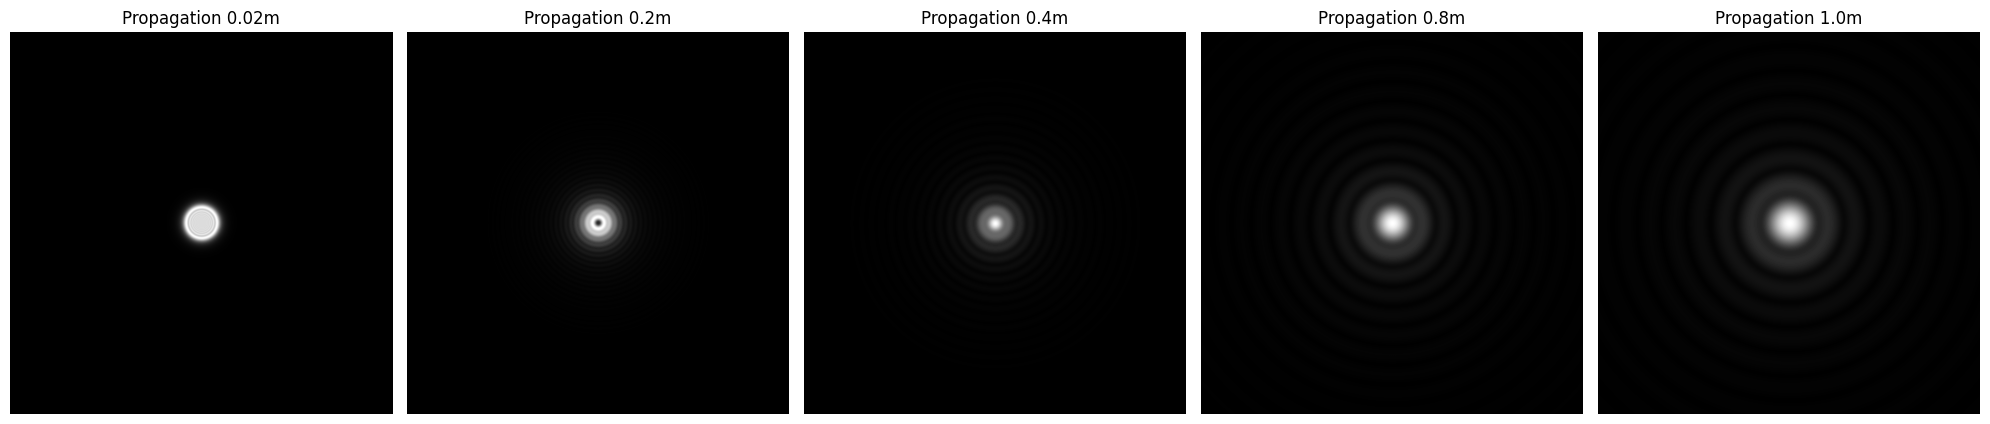

In [7]:
# fixed
source = source * np.exp(1j * np.zeros_like(source))
feature_size = (10 * um, 10 * um)

# experiment
wave_length = 633 * nm
prop_dist = [2 * cm, 20 * cm, 40 * cm, 80 * cm, 100 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

image_to_slm = []
for z in prop_dist:
    image_to_slm.append(
        propagation_asm(source, feature_size, wave_length, z)
    )

plt.figure(figsize=(20, 20))
for i, hologram in enumerate(image_to_slm):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(np.abs(hologram), cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

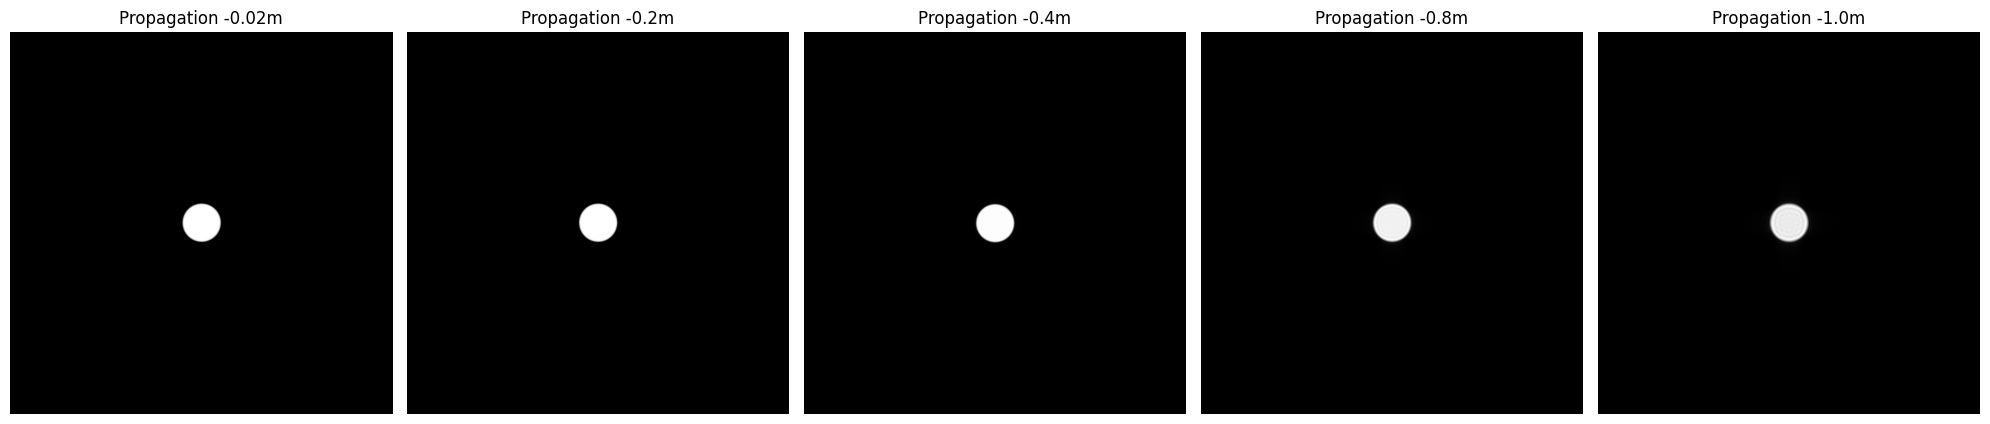

In [8]:
visualization_title = [f'Propagation -{z}m' for z in prop_dist]

slm_to_image = []
for z, hologram in zip(prop_dist, image_to_slm):
    slm_to_image.append(
        propagation_asm(hologram, feature_size, wave_length, -z)
    )

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(np.abs(image), cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 3-2. Wave length
Wave Length를 바꿔가며 실험해본다.

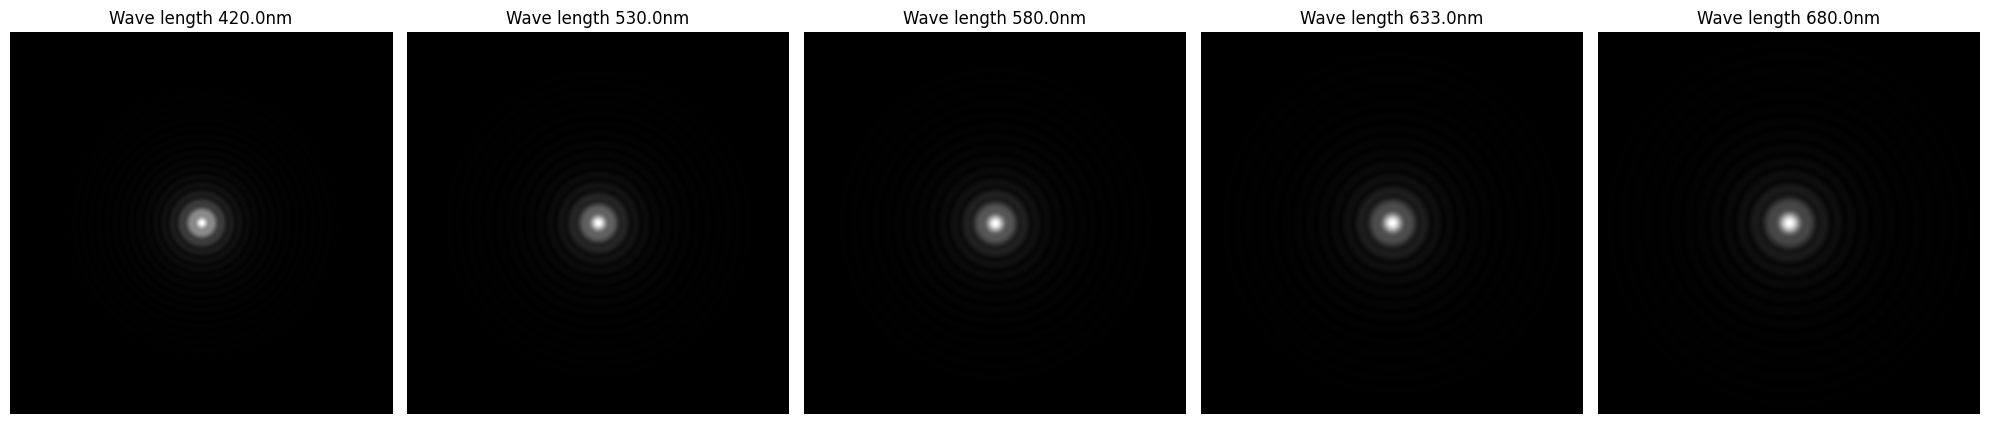

In [9]:
# fixed
feature_size = (10 * um, 10 * um)

# experiment
wave_lengths = [420 * nm, 530 * nm, 580 * nm, 633 * nm, 680 * nm]
z = 50 * cm
visualization_title = [f'Wave length {np.round(wave_length * (1 / nm))}nm' for wave_length in wave_lengths]

image_to_slm = []
for wave_length in wave_lengths:
    image_to_slm.append(
        propagation_asm(source, feature_size, wave_length, z)
    )

plt.figure(figsize=(20, 20))
for i, hologram in enumerate(image_to_slm):
    plt.subplot(1, len(wave_lengths), i + 1)
    plt.imshow(np.abs(hologram), cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

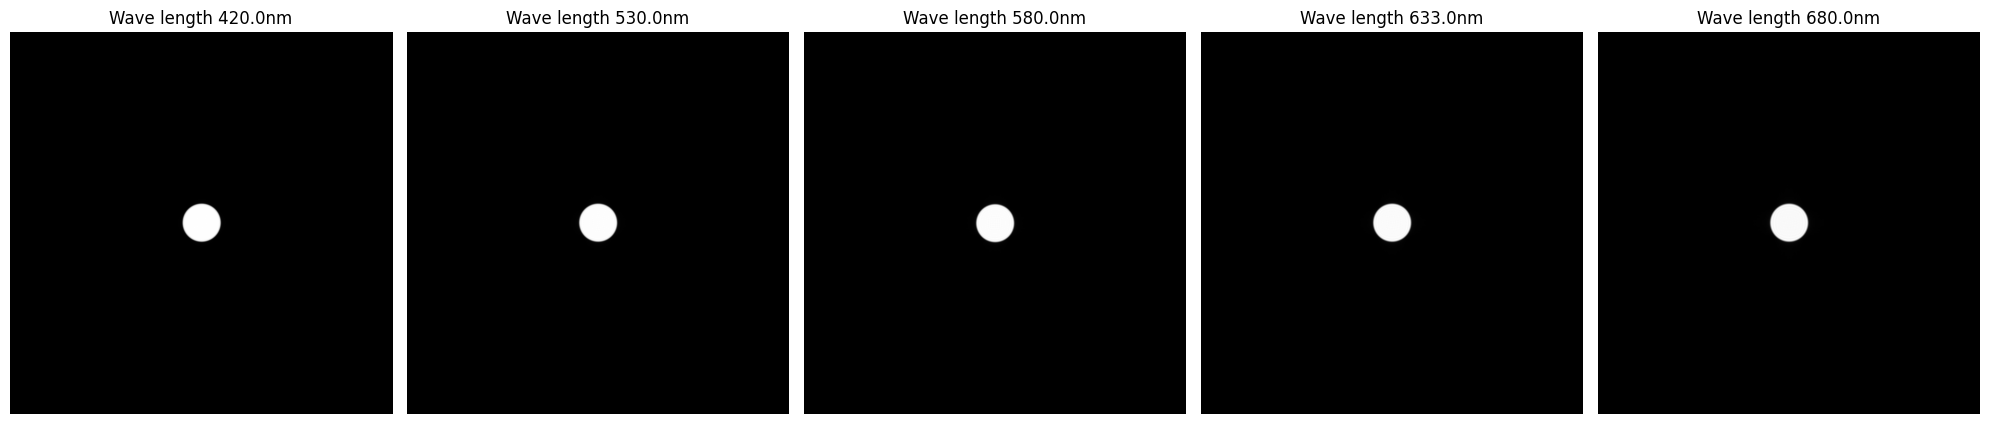

In [10]:
slm_to_image = []
for wave_length, hologram in zip(wave_lengths, image_to_slm):
    slm_to_image.append(
        propagation_asm(hologram, feature_size, wave_length, -z)
    )

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image):
    plt.subplot(1, len(wave_lengths), i + 1)
    plt.imshow(np.abs(image), cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 5. 2D Image

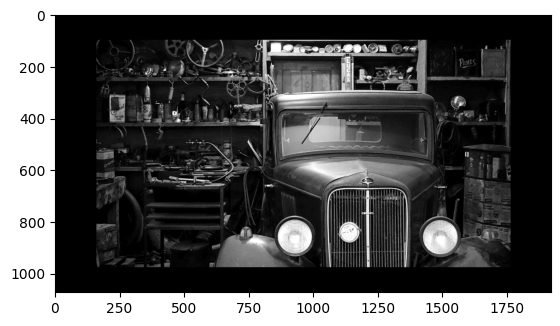

In [14]:
import skimage.io as sio
img = sio.imread('../assets/sample1.png')[:, :, 1]
plt.imshow(img, cmap='gray')
plt.show()

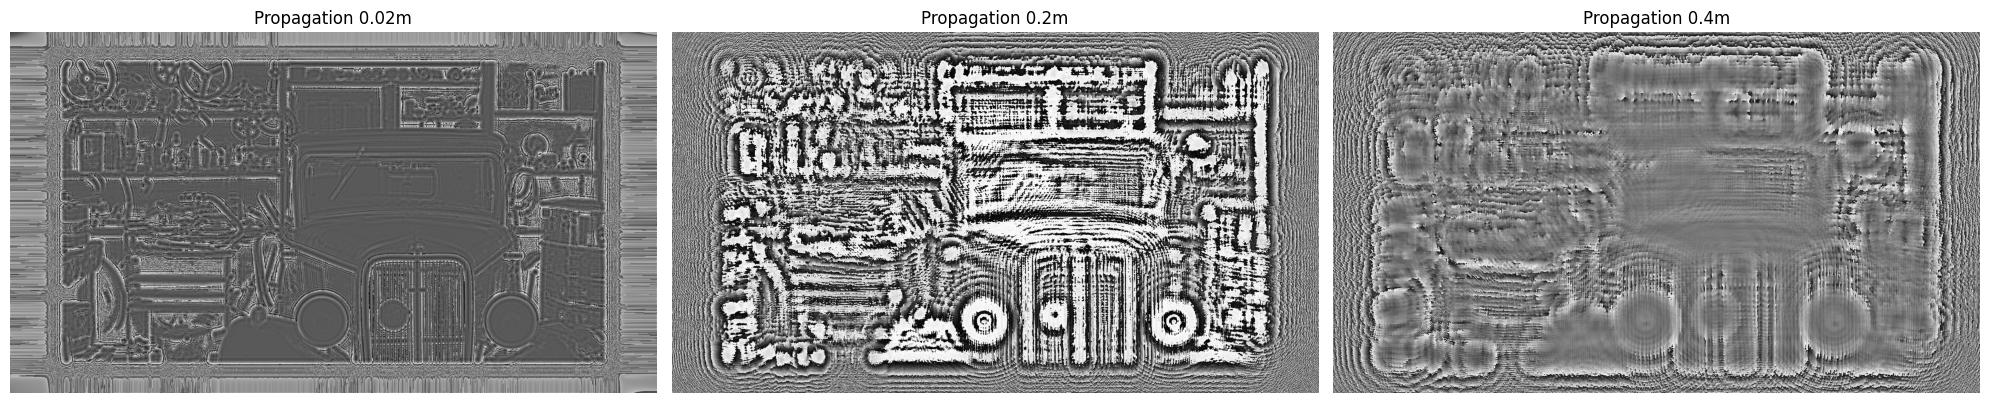

In [15]:
# fixed
img = img * np.exp(1j * np.zeros_like(img))
feature_size = (10 * um, 10 * um)

# experiment
wave_length = 530 * nm
prop_dist = [2 * cm, 20 * cm, 40 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

image_to_slm = []
for z in prop_dist:
    image_to_slm.append(
        propagation_asm(img, feature_size, wave_length, z)
    )

plt.figure(figsize=(20, 20))
for i, hologram in enumerate(image_to_slm):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(np.angle(hologram), cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

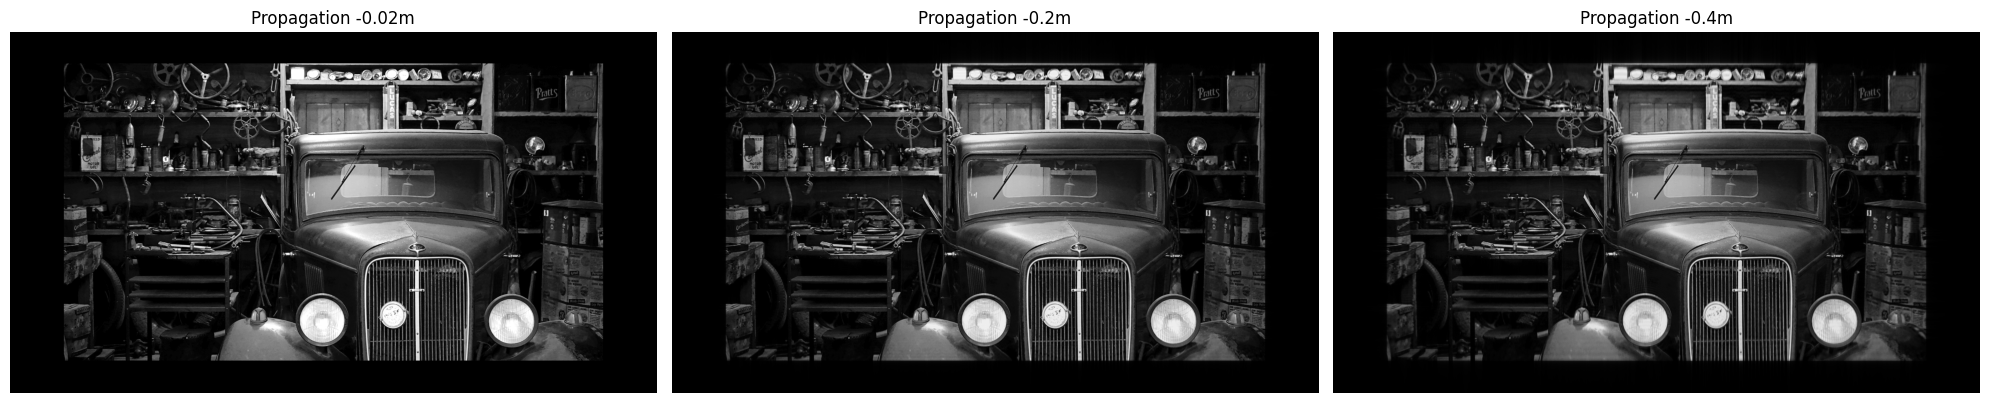

In [ ]:
visualization_title = [f'Propagation -{z}m' for z in prop_dist]

slm_to_image = []
for z, hologram in zip(prop_dist, image_to_slm):
    slm_to_image.append(
        propagation_asm(hologram, feature_size, wave_length, -z)
    )

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(np.abs(image), cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()